<img src='../frameworks/img/EU-Copernicus-EUM-WEKEO_banner_logo.png' align='right' width='75%'></img>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_6_OLCI_CHL_comparison.ipynb" target="_blank"><< Comparing OLCI chlorophyll products</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Learn OLCI: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
  - **<a href="./1_1a_OLCI_data_access_Data_Store.ipynb" target="_blank">1_1a_OLCI_data_access_Data_Store.ipynb</a>** (if using the Data Store)
    <br><br>**OR**<br><br>
  - **<a href="./1_1b_OLCI_data_access_HDA.ipynb" target="_blank">1_1b_OLCI_data_access_HDA.ipynb</a>** (if using WEkEO)
    
</div>
<hr>

# 1.7 Assessing the light environment

### Data used

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 OLCI level-2 full resolution | EO:EUM:DAT:0407 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%202%20Data&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_1_EFR___" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* How light penetrates in to the ocean
* What this means for ocean colour remote sensing
* How we can use this understanding for ocean applications


### Outline

Sunlight reaching the surface of the oceans penetrates below the surface. How far the light penetrates, depends on the relative and total concentrations of different optically significant constituents - phytoplankton, sediments, coloured dissolved organic matter etc. Where concentrations are low, light will typically penetrate much deeper than where concentrations of these constituents are high. The light penetration also varies spectrally, with light at blue wavelengths typically penetrating the deepest, and light at red wavelengths penetrating far less.

The light that penetrates the ocean surface, is absorbed and scattered, and a proportion is reflected back from the ocean. It is this reflected light that is measured by ocean colour satellite instruments like OLCI. Thus the ocean colour signal represents a combination of all these effects. In reality, the signal we measure from ocean colour satellites, represents a combination of these processes over a variable depth in the ocean. 

In this notebook we'll look at several parameters provided in the Sentinel-3 OLCI level-2 products, that can tell us about the light environment in the ocean.

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Light and transparency](#section1)
 1. [Photosynthetically Active Radiation (PAR)](#section2)
 1. [Light attenuation at 490 nm (Kd490)](#section3)

<hr>

In [1]:
import cartopy.crs as ccrs
import eumartools
import glob
import inspect
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import warnings
import xarray as xr
import cmocean

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Light and transparency
[Back to top](#TOC_TOP)

</div>

An understanding of how light interacts with ocean waters is fundamental to using ocean colour data, and deriving methods to link the signal with concentrations of different constituents - phytoplankton, sediments, coloured dissolved organic matter or otherwise.

It is also important when it comes to comparing satellite and in situ measurements, where we need to have an appreciation for what depth of water the signal actually represents, compared to our in situ measurements taken at discrete depths.

Finally, we may want to understand how light is penetrating in to the ocean as this is vital information for understanding several important ocean processes including:
* Ocean heat fluxes and upper ocean density structures
* Primary Production
* Light availability for benthic ecosystems

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Photosynthetically Active Radiation (PAR)
[Back to top](#TOC_TOP)

</div>

One very important parameter relating to the light environment in the ocean is Photosynethetically Active Radiation (PAR). This refers to the spectral range of light (400-700 nm) that organisms are able to use for photosynthetis.

Let's take a look at some PAR data from OLCI. 

First let's create a path to our data of interest, and the relevant quality flags.

In [2]:
SAFE_directory = os.path.join(os.getcwd(), 'products',
    'S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3')

flag_file = os.path.join(SAFE_directory,'wqsf.nc')

Next we'll reduce the resolution of the data to make our plotting more efficient in this interactive tutorial (for actual analysis, you would want to skip this!).

In [3]:
grid_reduce = 5

In the following cells, we'll open and read the latitude and longitude information, and the create the flag masks we will need.

In [4]:
geo_file = os.path.join(SAFE_directory,'geo_coordinates.nc')
geo_fid = xr.open_dataset(geo_file)
lon = geo_fid.longitude.data[::grid_reduce, ::grid_reduce]
lat = geo_fid.latitude.data[::grid_reduce, ::grid_reduce]
geo_fid.close()

In [5]:
# reading masks: example land
land_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND'])
land_mask = land_mask.astype(float)[::grid_reduce, ::grid_reduce]
land_mask[land_mask == 0.0] = np.nan

In [6]:
# reading masks: example cloud
cloud_mask = eumartools.flag_mask(flag_file, 'WQSF', ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN'])
cloud_mask = cloud_mask.astype(float)[::grid_reduce, ::grid_reduce]
cloud_mask[cloud_mask == 0.0] = np.nan

In [7]:
# reading masks: PAR recommended
PAR_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8',
                                                    'PAR_FAIL'])
PAR_mask = PAR_mask.astype(float)[::grid_reduce, ::grid_reduce]
PAR_mask[PAR_mask == 0.0] = np.nan

Next, we'll read in the PAR data.

In [8]:
band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'par.nc')))
band_vars.close()

Now we have everything we need, we can plot the data. 

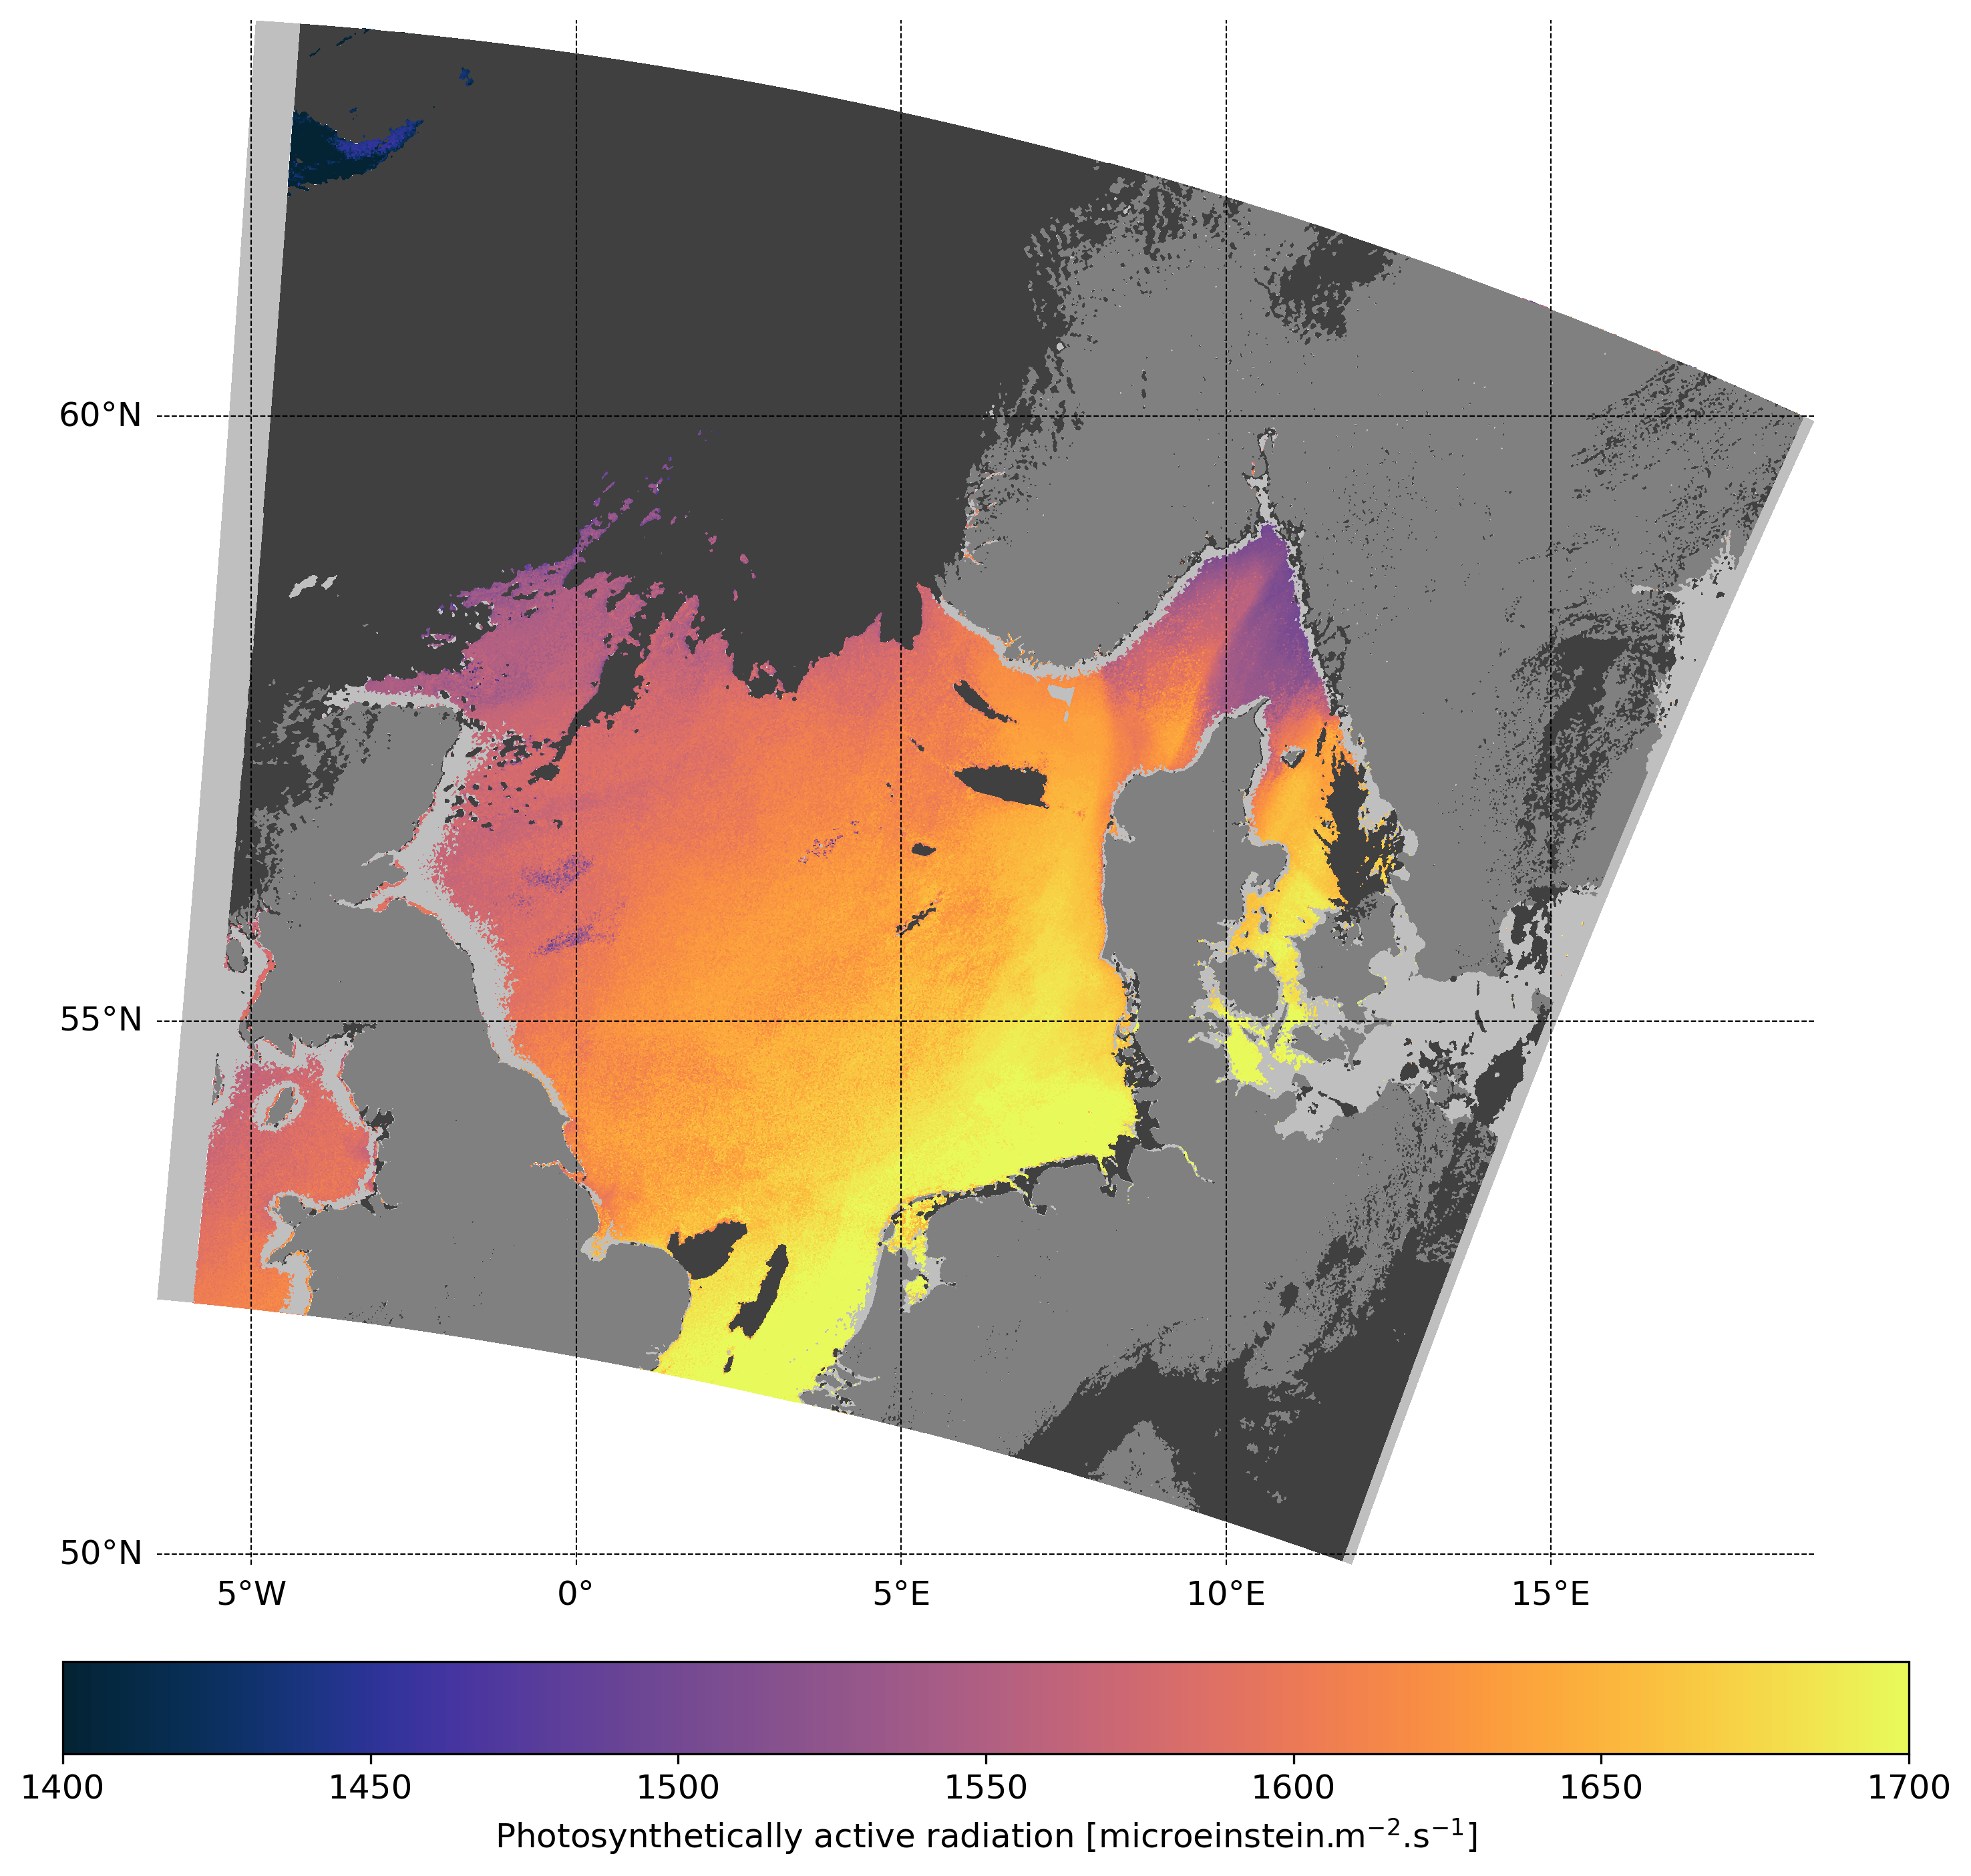

In [9]:
fig = plt.figure(figsize=(10, 10), dpi=300)
m = plt.subplot(projection=ccrs.Mercator())

p1 = m.pcolormesh(lon, lat, band_vars["PAR"][::grid_reduce, ::grid_reduce], transform=ccrs.PlateCarree(), 
                   cmap=cmocean.cm.thermal, vmin=1400, vmax=1700, zorder=1)

m.contourf(lon, lat, PAR_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
m.contourf(lon, lat, cloud_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')

cbar = fig.colorbar(p1, location='bottom', pad=0.05)
cbar.set_label('Photosynthetically active radiation [microeinstein.m$^{-2}$.s$^{-1}$]')

plt.tight_layout()
plt.savefig('1_7_OLCI_PAR.png', bbox_inches='tight')

What can we notice from this plot? Firstly, you will probably notice that there is a gradual increase in PAR from the top right, to bottom left of the image. This is due to the variation in the incident light from the sun as a function of the time of day (Earths rotation) and season (Earths tilt) when the satellite was passing overhead. 

You'll also notice that there is some more patchy variability - related to variability in the atmosphere. 

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Light attenuation at 490 nm (K$_d$(490))
[Back to top](#TOC_TOP)

</div>

There's another parameter available in the OLCI level-2 products that can give us useful information about the light environment in the ocean.

The Diffuse Attenuation Coefficient (K$_{d}$) at 490 nm can tell us how rapidly light is attenuated over depth, and thus also, by inversion, how deep light is penetration. 

The K$_{d}$(490) product in OLCI is derived using the method of Morel et al., (2007)

    
Morel, A.; Huot, Y.; Gentili, B.; Werdell, P.J.; Hooker, S.B.; Franz, B.A. Examining the consistency of products
derived from various ocean color sensors in open ocean (Case 1) waters in the perspective of a multi-sensor
approach. Remote. Sens. Environ. 2007, 111, 69–88.

$E_{d}(z,\lambda) = E_{d}(0,\lambda)\exp(-K_{d}(\lambda).z)$

We can also use this value to estimate the depth at which the light level reaches 1% of the surface value, using the equation below.

$Z_{490} = \frac{\ln(E_{d}(z,490) / E_{d}(0,490))}{-K_{d}(490)} = \frac{4.595}{-K_{d}(490)}$


First we'll read in the K$_{d}$(490) data which can be found in the 'trsp' netcdf file (trsp being short for transparency).

In [10]:
band_vars2 = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'trsp.nc')))
band_vars2.close()

Next we'll create the relevant mask.

In [11]:
# reading masks: PAR recommended
KDM_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8',
                                                    'KDM_FAIL'])
KDM_mask = KDM_mask.astype(float)[::grid_reduce, ::grid_reduce]
KDM_mask[KDM_mask == 0.0] = np.nan

Then we can plot the data...

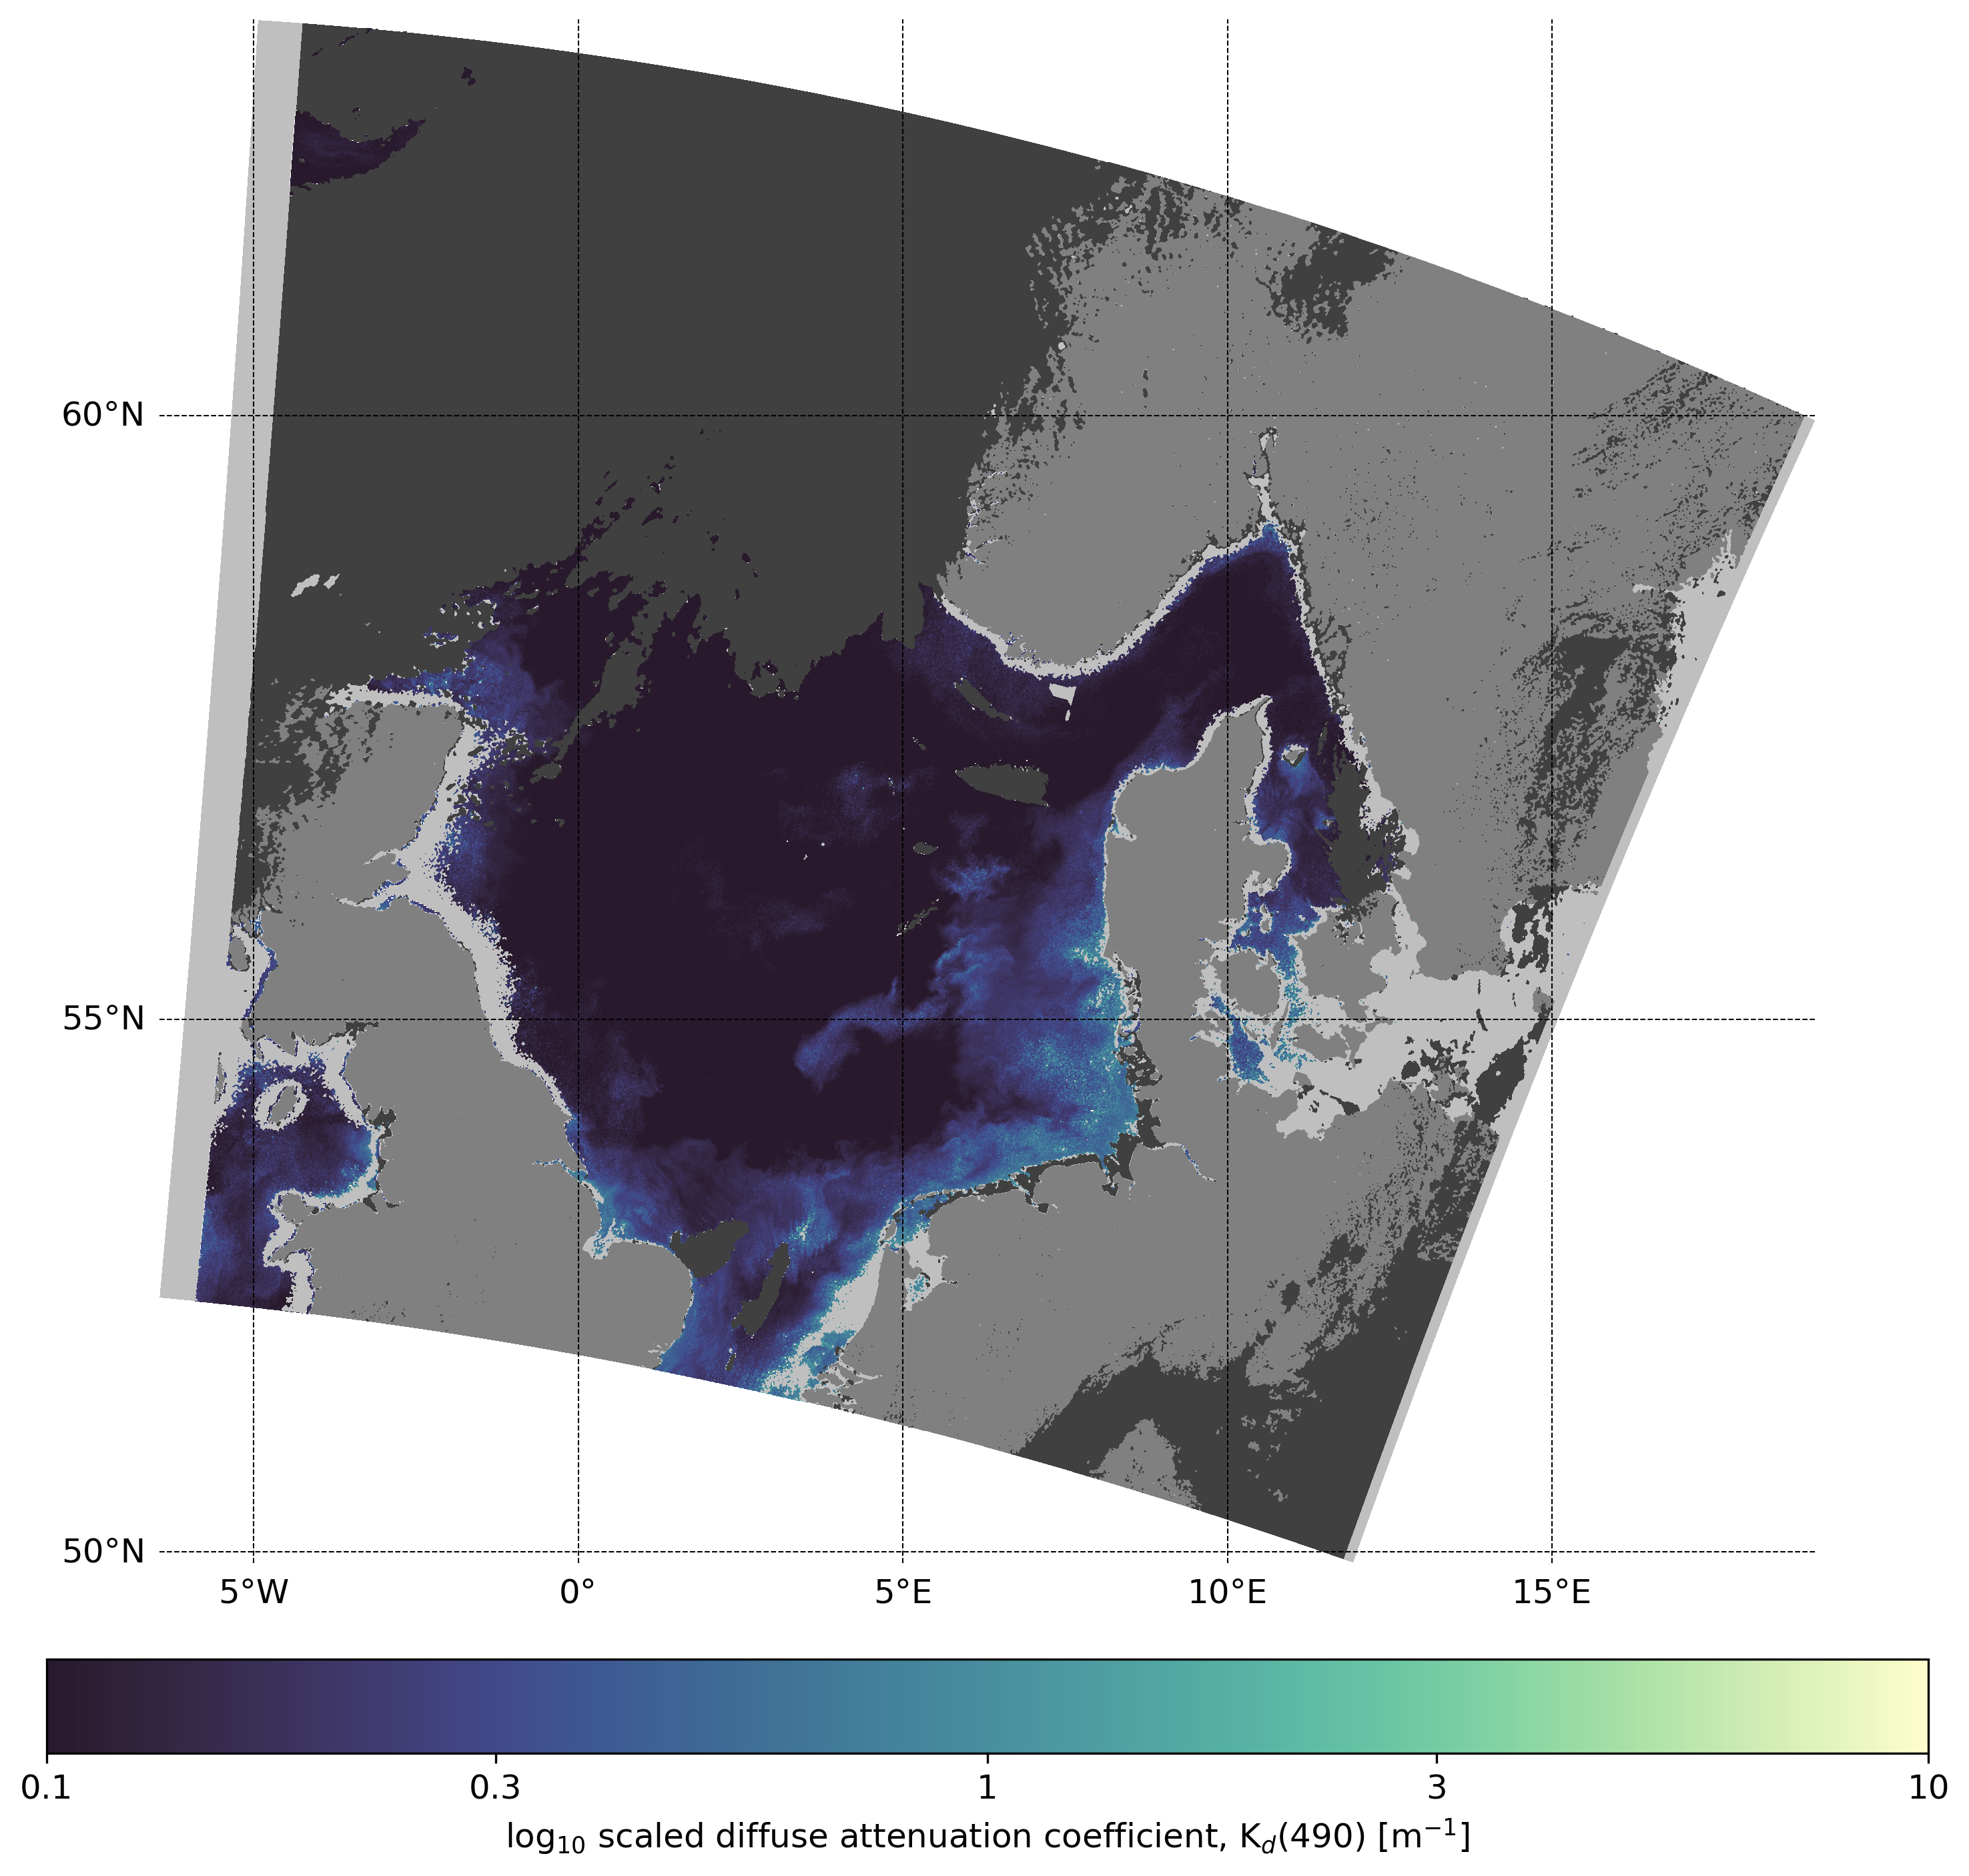

In [12]:
fig, m = plt.subplots(1, 1, figsize=(10, 10), dpi=300, subplot_kw={"projection": ccrs.Mercator()})

p1 = m.pcolormesh(lon, lat, band_vars2["KD490_M07"][::grid_reduce, ::grid_reduce], transform=ccrs.PlateCarree(), 
                   cmap=cmocean.cm.deep_r, vmin=-1, vmax=1)

m.contourf(lon, lat, KDM_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
m.contourf(lon, lat, cloud_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')

cbar = fig.colorbar(p1, location='bottom', pad=0.05)
cbar.set_label('log$_{10}$ scaled diffuse attenuation coefficient, K$_{d}$(490) [m$^{-1}$]')
ticks = [0.1, 0.3, 1, 3, 10]
cbar.set_ticks(np.log10(ticks))
cbar.set_ticklabels(ticks)

plt.tight_layout()
plt.savefig('1_7_OLCI_KD490.png', bbox_inches='tight')

Higher values of K$_{d}$(490) show where light is being rapidly attenuated. If we look back to the <a href="./1_6_OLCI_CHL_comparison.ipynb" target="_blank">previous notebook</a> we can understand why. In the coastal regions, where chlorophyll-a, sediments, and coloured dissolved organic matter concentrations are highest, light is more rapidly attenuated. This is because these constituents absorb light. They also scatter light, which can reduce penetration (though this does not necessarily mean the light is scattered directly back out of the ocean - if you are really interested in the mysteries of scattering - check out the <a href="https://www.oceanopticsbook.info/view/radiative-transfer-theory/level-2/the-single-scattering-approximation" target="_blank">Ocean Optics web book</a>.

We can also plot the estimate we derived of the depth of the 1% light level to understand how deep light is penetrating in to the ocean in this image...

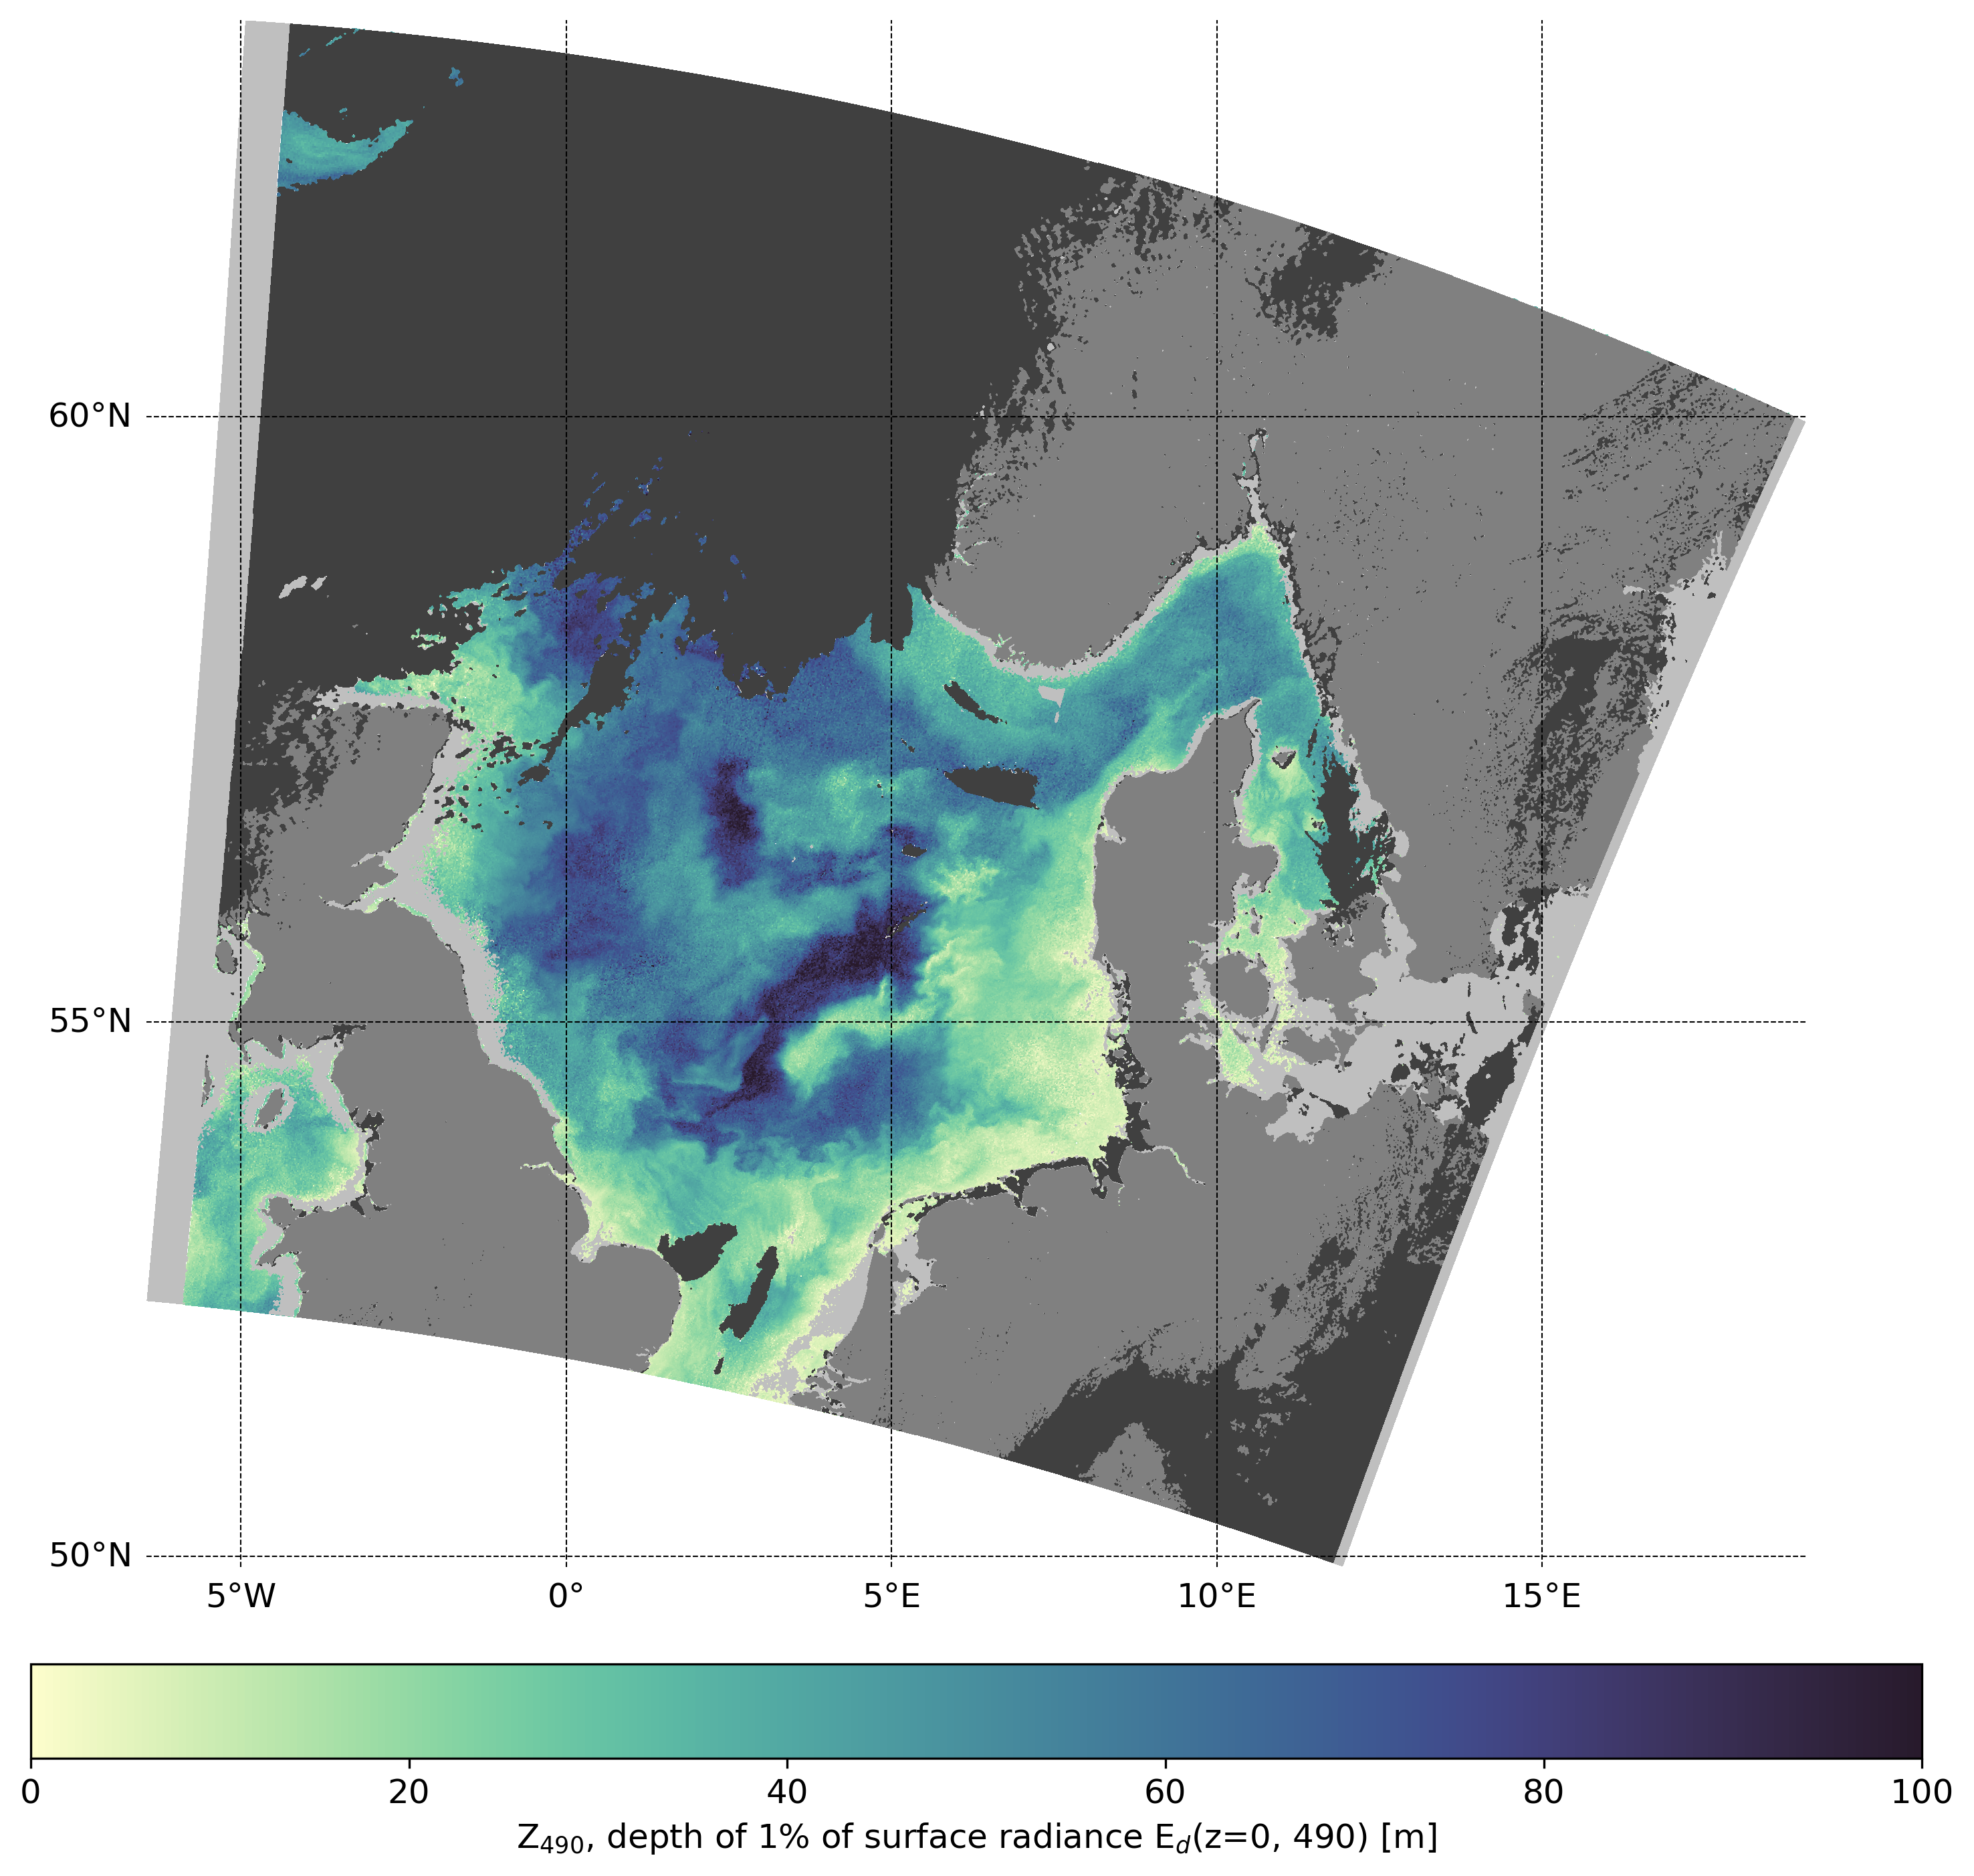

In [13]:
fig, m = plt.subplots(1, 1, figsize=(10, 10), dpi=300, subplot_kw={"projection": ccrs.Mercator()})

p1 = m.pcolormesh(lon, lat, 4.595 / 10**band_vars2["KD490_M07"][::grid_reduce, ::grid_reduce],
                  transform=ccrs.PlateCarree(), cmap=cmocean.cm.deep, vmin = 0, vmax = 100)

m.contourf(lon, lat, KDM_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
m.contourf(lon, lat, cloud_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')

cbar = fig.colorbar(p1, location='bottom', pad=0.05)
cbar.set_label('Z$_{490}$, depth of 1% of surface radiance E$_d$(z=0, 490) [m]')

plt.tight_layout()
plt.savefig('1_7_OLCI_Z490.png', bbox_inches='tight')

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_6_OLCI_CHL_comparison.ipynb" target="_blank"><< Comparing OLCI chlorophyll products</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>